<a href="https://colab.research.google.com/github/sn0422j/mt_deep/blob/master/Volterra_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 非線形なBOLD反応

神経活動と共に血流流量が増加することで、BOLD反応が重ね合わせの原理を破ることがある。重ね合わせの原理を破るということは、線形関係が成り立たない非線形な反応が生じるということである。

非線形な応答をモデル化した有名な例は **バルーンモデル** (Balloon model; [Buxton et al. (1998)](https://doi.org/10.1002/mrm.1910390602)) であり、神経活動からBOLD反応が生成する過程を詳細にモデル化することで非線形な反応をモデル化した。

しかし、バルーンモデルは複雑であるために計算量が膨大となってしまう。そこで、非線形性だけに注目し、非線形系理論を応用することで計算量を削減することができる。ここでは、**ボルテラモデル** (Volterra model) という非線形系のモデルを利用してBOLD反応をモデル化する。

# ボルテラモデル (Volterra model)

時間不変なシステムは、入出力の関係をボルテラ級数で表現できる。ここで、$h_k$ を $k$ 次ボルテラカーネルという。

$$
\begin{alignedat}{2}
y(t) = \ & h_0 + \int h_1(\tau_1) x(t-\tau_1) d\tau_1 \\
&+ \int \int h_2(\tau_1, \tau_2) x(t-\tau_1) x(t-\tau_2) d\tau_1 d\tau_2 + \cdots
\end{alignedat}
$$

ボルテラ級数を用いて、BOLD反応 $y(t)$ と 神経活動 $N(t)$ の関係を表現する。

$$
\begin{alignedat}{2}
y(t) &= \sum_{i=1}^\infty H_i[N(t)] \\ 
\text{where} \\
& H_i[N(t)] = \int \cdots \int h_i(\tau_1, \dots, \tau_2) N(t-\tau_1) \cdots N(t-\tau_i) d\tau_1 \dots d\tau_i
\end{alignedat}
$$

[Friston et al. (1998)](https://doi.org/10.1002/mrm.1910390109) は、非線形なBOLD応答は次の式で近似できるとした。

$$
\begin{alignedat}{2}
y(t) = \ & H_1[N(t)] + H_2[N(t)] \\
= \ & \int_0^t N(\tau_1) h_1(t- \tau_1) d\tau_1 \\
& + \int_0^t \int_0^t h_2 (\tau_1, \tau_2) N(t-\tau_1) N(t-\tau_2) d\tau_1 d\tau_2　\\  
\end{alignedat}
$$

さらに、[Friston et al. (1998)](https://doi.org/10.1002/mrm.1910390109) では、$2$ 次ボルテラカーネルを次のように設計した。

$$
h_2 (\tau_1, \tau_2)=\sum_{i=1}^3 \sum_{j=1}^3 \beta_{ij}b_i(\tau_1)b_j(\tau_2)
$$

ここで、$b(\tau)$ は次のようなガンマ基底関数である。

$$
\begin{alignedat}{2}
b_1(\tau) &= \frac{1}{3!} \tau^3 e^{-\tau} \\
b_2(\tau) &= \frac{1}{7!} \tau^7 e^{-\tau} \\
b_3(\tau) &= \frac{1}{15!} \tau^{15} e^{-\tau} \\
\end{alignedat}
$$

したがって、BOLD反応の $2$ 次ボルテラモデルは次のようになる。

$$
\begin{alignedat}{2}
y(t) = \ & \sum_{i=1}^3 \alpha_i [b_i(t) \ast N(t)] \\
& + \sum_{i=1}^3 \sum_{j=1}^3 \beta_{ij} [b_i(t) \ast N(t)] [b_j(t) \ast N(t)] \\
= \ & \sum_{i=1}^3 \alpha_i x_i(t) + \sum_{i=1}^3 \sum_{j=1}^3 \beta_{ij} x_i(t) x_j(t)
\end{alignedat}
$$



# シミュレーション

次の例では、$\alpha_1 = \alpha_2 = \alpha_3 = 0.2, \ \beta_{11}=0.1, \ \beta_{13} = -0.2$ とし、他のパラメータを $0$ とした。

まずは、１回の神経活動に対してシミュレーションする。

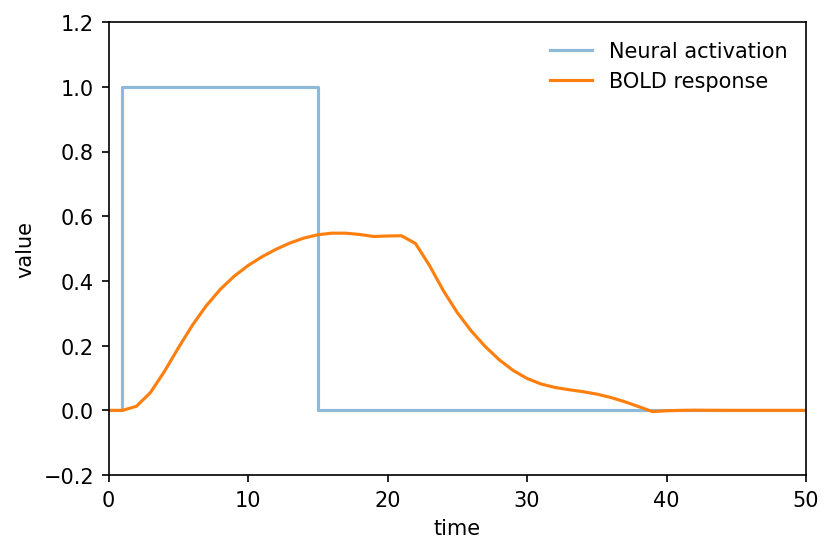

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Set the experimental condition
time = np.arange(100)
boxcar = np.zeros(100); boxcar[1:21] = np.ones(20)

# Calculate a Volterra series.
def volterra_bold(time, boxcar, alpha = [0.2, 0.2, 0.2], beta = [[0.1, 0, -0.2], [0, 0, 0], [0, 0, 0]]):
    b1 = ((np.power(time, 3)) * np.exp(-time) ) / math.factorial(3)
    b2 = ((np.power(time, 7)) * np.exp(-time) ) / math.factorial(7)
    b3 = ((np.power(time, 15)) * np.exp(-time) ) / math.factorial(15)
    x1 = np.convolve(boxcar, b1)
    x2 = np.convolve(boxcar, b2)
    x3 = np.convolve(boxcar, b3)
    x = np.array([x1, x2, x3])

    alpha = np.array(alpha)
    H1 = np.dot(alpha, x)

    beta = np.array(beta)
    H2 = np.dot(beta.flatten(),
                (np.array([x,x,x]) * np.array([x,x,x])).reshape(9,-1))
    return H1 + H2

# Plot the results.
time_for_display = [0,1] + list(range(1,16)) + list(range(15,100))
boxcar_for_display = [0]*2 + [1]*15 + [0]*85
f, ax = plt.subplots(1,1,dpi=150)
ax.plot(time_for_display, boxcar_for_display,
        label='Neural activation', alpha=0.5)
ax.plot(volterra_bold(time, boxcar),
        label='BOLD response')
ax.set_xlim(0,50); ax.set_ylim(-0.2,1.2)
ax.set_xlabel('time'); ax.set_ylabel('value')
ax.legend(loc='best', frameon=False)
plt.savefig('volterra_hrf1.png')
plt.show()

次に、複数回の神経活動に対してもシミュレーションする。

ここでは、全ての $\beta=0$ とした線形モデルも一緒にシミュレーションする。

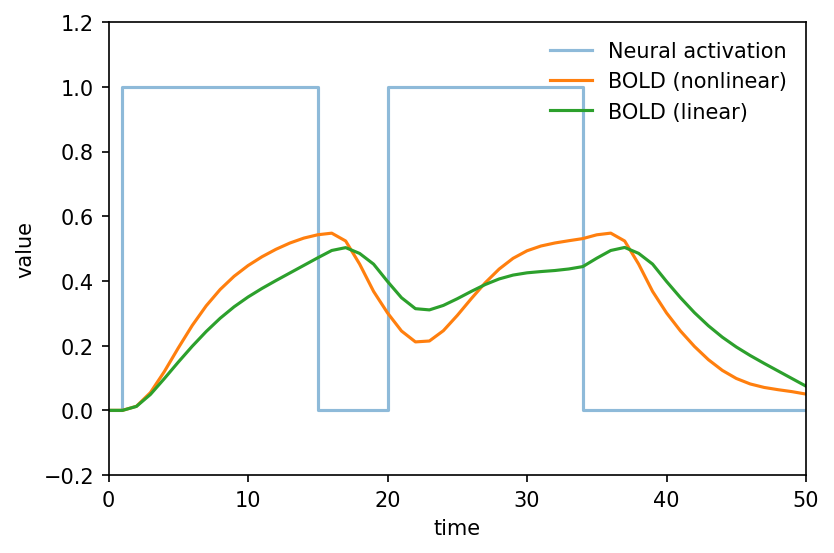

In [2]:
# Set the experimental condition
time = np.arange(100)
boxcar = np.zeros(100); boxcar[1:16] = np.ones(15); boxcar[21:36] = np.ones(15); 

# Plot the results.
time_for_display = [0,1] + list(range(1,16)) + list(range(15,21)) + list(range(20, 35)) + list(range(34, 100))
boxcar_for_display = [0]*2 + [1]*15 + [0]*6 + [1]*15 + [0]*66
f, ax = plt.subplots(1,1,dpi=150)
ax.plot(time_for_display, boxcar_for_display,
        label='Neural activation', alpha=0.5)
ax.plot(volterra_bold(time, boxcar),
        label='BOLD (nonlinear)')
ax.plot(volterra_bold(time, boxcar, beta=[[0]*3,[0]*3,[0]*3]),
        label='BOLD (linear)')
ax.set_xlim(0,50); ax.set_ylim(-0.2,1.2)
ax.set_xlabel('time'); ax.set_ylabel('value')
ax.legend(loc='upper right', frameon=False)
plt.savefig('volterra_hrf2.png')
plt.show()

#### Reference
- Ashby, F. G. (2019). Statistical analysis of fMRI data. MIT press.
- Buxton, R. B., Wong, E. C., & Frank, L. R. (1998). Dynamics of blood flow and oxygenation changes during brain activation: the balloon model. Magnetic resonance in medicine, 39(6), 855-864.
- Friston, K. J., Josephs, O., Rees, G., & Turner, R. (1998). Nonlinear event‐related responses in fMRI. Magnetic resonance in medicine, 39(1), 41-52.
